<figure>
<IMG SRC="../../lectures/images/PhysicsLogo.jpg" WIDTH=100 ALIGN="right">
</figure>
# [Physics 411](http://jklymak.github.io/Phy411/) Time Series Analysis
*Jody Klymak*


# Assignment 8

### **Q1** Sampling theorem and aliasing

<div style='background:#F0F0F0'>**1** Create a band-limited white noise timeseries with $N=1000$ entries, $dt=0.1 s$, but with all frequencies greater than 0.5 Hz filtered.  Plot the power spectrum to make sure you got it correctly...
</div>

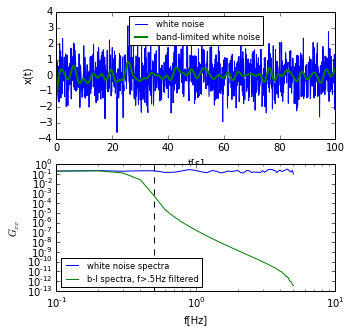

In [13]:
import numpy.random as random
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.signal as signal
import numpy.linalg as la

%matplotlib inline


N=1000
dt=0.1#s
x=np.random.randn(N)
t=np.arange(0,N*dt, dt)
B=0.5
wp=B*0.7
ws=B*0.9
fNy=1./2/dt
n,wn= signal.ellipord(wp/fNy, ws/fNy, 0.1, 60.)
b,a= signal.ellip(n,0.1,60,wn)
xbl= signal.filtfilt(b,a,x)

nfft=100
Gxx,fx=mlab.psd(x,NFFT=nfft,Fs=1./dt,noverlap=nfft/2.,window=mlab.window_hanning)
Gbl,fbl=mlab.psd(xbl,NFFT=nfft,Fs=1./dt,noverlap=nfft/2.,window=mlab.window_hanning)
fig,ax=plt.subplots(2,1,figsize=(5,5))
ax[0].plot(t,x,label='white noise')
ax[0].plot(t,xbl,label='band-limited white noise', linewidth=2)
ax[0].set_xlabel('t[s]')
ax[0].set_ylabel('x(t)')
ax[0].legend(loc=0,fontsize='small' )

ax[1].loglog(fx,Gxx,label='white noise spectra')
ax[1].loglog(fbl,Gbl,label='b-l spectra, f>.5Hz filtered')
ax[1].set_xlabel('f[Hz]')
ax[1].set_ylabel('$G_{xx}$')
ax[1].legend(loc=0,fontsize='small' )
plt.axvline(x=B,linestyle='--',color='k')

<div style='background:#F0F0F0'>**2** Now decimate by a factor of 4 to get a time series sampled at 2.5 Hz.  Show that you can recover the 10 Hz time series using the Sampling Theorem.</div>

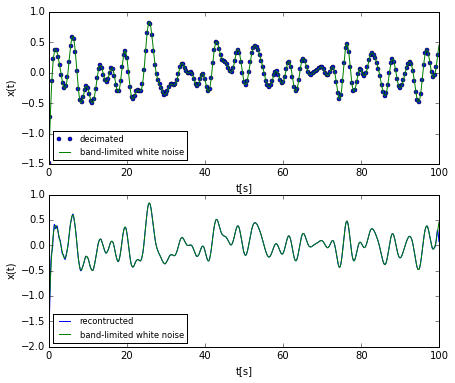

In [14]:
dec=4
td=t[::dec]
xd=xbl[::dec]
fig,ax=plt.subplots(2,1,figsize=(7,6))
ax[0].plot(td,xd,'o',label='decimated', markersize=4)
ax[0].plot(t,xbl,label='band-limited white noise', linewidth=1)
ax[0].set_xlabel('t[s]')
ax[0].set_ylabel('x(t)')
ax[0].legend(loc=0,fontsize='small' )

Nd=len(xd)
n=np.arange(Nd)
#reconstruct the series from xd
B2=2.5#because now we want to sample more often
xreco= 1.*xbl[:Nd*dec]  # trim last Nd*dec data points
for i in range(Nd*dec):
    xreco[i]=np.sum(xd[:Nd]*np.sinc(B2*t[i]-n))
ax[1].plot(t,xreco,label='recontructed')
ax[1].plot(t,xbl,label='band-limited white noise', linewidth=1)
ax[1].set_xlabel('t[s]')
ax[1].set_ylabel('x(t)')
ax[1].legend(loc=0,fontsize='small' )

It looks like the reconstructed series worked really well, I was able to recover the original time series. 

<div style='background:#F0F0F0'>**3** Now decimate by a factor of 40 to get a time series sampled at 0.25 Hz.  Show that you cannot recover the 10 Hz time series using the Sampling Theorem.</div>

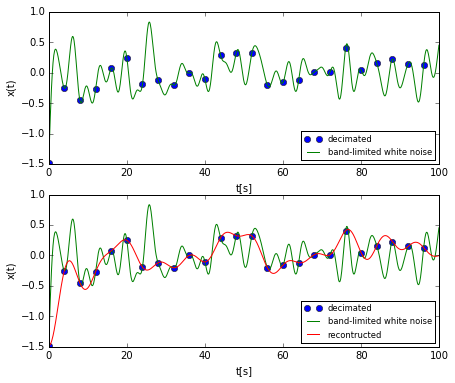

In [15]:
dec=40
td=t[::dec]
xd=xbl[::dec]
fig,ax=plt.subplots(2,1,figsize=(7,6))
ax[0].plot(td,xd,'o',label='decimated' )
ax[0].plot(t,xbl,label='band-limited white noise' )
ax[0].set_xlabel('t[s]')
ax[0].set_ylabel('x(t)')
ax[0].legend(loc=0,fontsize='small' )

Nd=len(xd)
n=np.arange(Nd)
#reconstruct the series from xd
B2=0.25#because now we want to sample more often
xreco= 1.*xbl[:Nd*dec]  # trim last Nd*dec data points
for i in range(Nd*dec):
    xreco[i]=np.sum(xd[:Nd]*np.sinc(B2*t[i]-n))
ax[1].plot(td,xd,'o',label='decimated' )
ax[1].plot(t,xbl,label='band-limited white noise', linewidth=1)
ax[1].plot(t,xreco,label='recontructed')
ax[1].set_xlabel('t[s]')
ax[1].set_ylabel('x(t)')
ax[1].legend(loc=0,fontsize='small' )

This reconstruction did not work so well. Because there were so few points to base the series on, and the points did not exhibit the true variability of the original (red) bandlimited series, the reconstruction is not so nice. 
Thus, the more data we have, the better the time series

## Q2: Cubic Spline

Using the data below...

In [2]:
t = np.array([0.,2.5,2.7,3.4,4.2,6.5,9.0])
x= np.cos(t*2*np.pi/3)


**1** Perform a cubic spline interpolation onto an even grid from 0 to 9.0 by 
  
  1. creating the matrix from the notes
  2. inverting and solving for the cubic co-efficients
  3. using those polynomials to evaluate the interpolated data.

Compare with using `scipy.interpolate.interp1d`.
Comment on any similarities or differences between the two results.

In [3]:
xl=len(x)
N=xl-1
mat=np.zeros((xl,xl))
delt=np.diff(t)
mat[0][0]=1
mat[N][N]=1
#find end
end=np.zeros(xl)
delx=np.diff(x)
for i in range(1,N):
    mat[i][i-1]=delt[i-1]
    mat[i][i]=2.*(delt[i-1]+delt[i])
    mat[i][i+1]=delt[i]  
    end[i]=(delx[i]/delt[i]-delx[i-1]/delt[i-1])
print 'The matrix: '
print mat

The matrix: 
[[ 1.   0.   0.   0.   0.   0.   0. ]
 [ 2.5  5.4  0.2  0.   0.   0.   0. ]
 [ 0.   0.2  1.8  0.7  0.   0.   0. ]
 [ 0.   0.   0.7  3.   0.8  0.   0. ]
 [ 0.   0.   0.   0.8  6.2  2.3  0. ]
 [ 0.   0.   0.   0.   2.3  9.6  2.5]
 [ 0.   0.   0.   0.   0.   0.   1. ]]


In [4]:
# find inverse
inv=la.inv(mat)

#solve [ci....]=inv end
cs=np.dot(inv,3.*end)

ds=0.*cs
ds[N-1]=(-2.*cs[N-1])/6./delt[N-1]
for i in range(0,N-1):
    ds[i]=(cs[i+1]-cs[i])/3./delt[i]
bs=0.*cs
for i in range(0,N):
    bs[i]=(x[i+1]-x[i]-delt[i]**2*cs[i]-delt[i]**3*ds[i])/delt[i]
print 'cubic coefficients:\nai\'s:'
print x
print 'bi\'s:'
print bs
print 'ci\'s:'
print cs
print 'di\'s:'
print ds

cubic coefficients:
ai's:
[ 1.          0.5         0.80901699  0.66913061 -0.80901699  0.5         1.        ]
bi's:
[-1.0834475   1.566895    1.28943751 -1.46519101 -1.42246417  1.00765611
  0.        ]
ci's:
[ -4.87182303e-16   1.06013700e+00  -2.44742444e+00  -1.48775915e+00
   1.54116770e+00  -4.84593664e-01   0.00000000e+00]
di's:
[ 0.1413516  -5.84593574  0.45698347  1.26205285 -0.2935886   0.06461249
  0.        ]


In [9]:
#make q array that holds each qi
q=np.zeros((N,20))
time=np.zeros((N,20))
# make q array that holds all qi for each segment
qt=np.zeros(N*20)
tt=np.zeros(N*20)
count=0
for i in range(N):
    time=np.linspace(t[i],t[i+1]-0.00001,20)
    for j in range(0,20):
        q[i][j]=x[i]+bs[i]*(time[j]-t[i])+cs[i]*(time[j]-t[i])**2+ds[i]*(time[j]-t[i])**3
        qt[count]=q[i][j]
        tt[count]=time[j]
        count=count+1
ti=np.linspace(0.0, 9.0, 1000)      
xreal=np.cos(ti*2*np.pi/3)

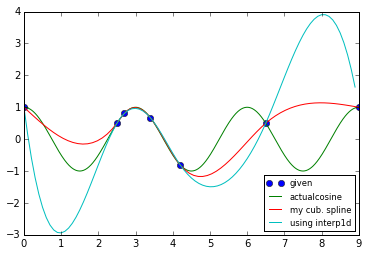

In [12]:
from scipy.interpolate import interp1d
ff=interp1d(t,x,kind='cubic')
time=np.arange(0., 9.0,0.1 )
xint=ff(time) 
fig, ax=plt.subplots(1,1)
ax.plot(t,x,'o',label='given')
ax.plot(ti, xreal, label='actualcosine')
ax.plot(tt,qt,label='my cub. spline')
ax.plot(time, xint, label='using interp1d')
ax.legend(loc=4, fontsize='small')

The matrix cubic spline interpolation looks like it has a better fit, only because it has smaller amplitudes compared to the `scipy.interpolate.interp1d` fit. Both of the interpolated fits are of the right concavity, compared to the cosine, until the last segment( from the second last blue point until the last, $q_5$), which is good. 
Where the given data was spaced closer together, the fit for both looks really good. But neither capture the fact that it is a cosine wave. 